# Output a set of validated transitions

Here, we output a curated table with transitions for all top level ESCO occupations, that are both `safe and desirable` according to the career transitions algorithm, and `feasible` according to the crowdsourced feasibility judgments (or predicted feasibility judgements if crowd data was not available).

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble_Transitions.ipy
import mapping_career_causeways.models.predict_model as model
import os 

data = load_data.Data()
sims = load_data.Similarities()

In [2]:
# Input data path
safe_transition_filepath = f'{data_folder}processed/validation/transitions_Safe_Desirable_Validated.csv'

# Output data
output_folder = useful_paths.project_dir + '/supplementary_online_data/transitions/'
file_name = 'mcc_transitions_table_Validated.csv'

# 1. Get feasibility estimates for all safe and desirable transitions

In [3]:
# Find all transitions above the minimal similarity threshold
transitions_master_table = trans_utils.get_transitions(verbose=True)

Finding all transitions... Done!
This took 18.53 seconds.


In [4]:
# Add crowdsourced and predicted feasibility ratings
if os.path.exists(safe_transition_filepath):
    safe_transitions = pd.read_csv(safe_transition_filepath)
else:
    # (will take some while for generating all the predictions)
    safe_transitions = transitions_master_table[transitions_master_table.is_safe_desirable]
    safe_transitions = model.add_feasibility_predictions(safe_transitions, add_crowd_data=True)
    safe_transitions.to_csv(safe_transition_filepath, index=False)


In [5]:
safe_transitions.head(1)

,origin_id,origin_label,destination_id,destination_label,similarity,is_jobzone_ok,is_earnings_ok,is_not_high_risk,is_safer,is_strictly_safe,...,W_work_context,sim_category,is_viable,is_desirable,is_safe_desirable,is_strictly_safe_desirable,feasibility,is_feasible,feasibility_predicted,is_feasible_predicted
0,1,metal drawing machine operator,1901,extrusion machine operator,0.845804,True,True,True,False,False,...,1.0,highly_viable,True,True,True,False,NaN,NaN,3.051092,True


In [6]:
# Select only transitions that are also predicted to be feasible by the predictive model or the crowd
safe_validated_transitions = safe_transitions[
    safe_transitions.is_feasible_predicted | (safe_transitions.is_feasible)
]

In [7]:
print(f'Total number of safe and desirable transitions: {len(safe_transitions)}')
print(f"Total number of 'feasible' safe and desirable transitions: {len(safe_validated_transitions)}")

Total number of safe and desirable transitions: 65126
Total number of 'feasible' safe and desirable transitions: 26642


In [8]:
safe_validated_transitions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26642 entries, 0 to 65107
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   origin_id                   26642 non-null  int64  
 1   origin_label                26642 non-null  object 
 2   destination_id              26642 non-null  int64  
 3   destination_label           26642 non-null  object 
 4   similarity                  26642 non-null  float64
 5   is_jobzone_ok               26642 non-null  bool   
 6   is_earnings_ok              26642 non-null  bool   
 7   is_not_high_risk            26642 non-null  bool   
 8   is_safer                    26642 non-null  bool   
 9   is_strictly_safe            26642 non-null  bool   
 10  job_zone_dif                26642 non-null  float64
 11  earnings_ratio              26642 non-null  float64
 12  risk_dif                    26642 non-null  float64
 13  prop_dif                    266

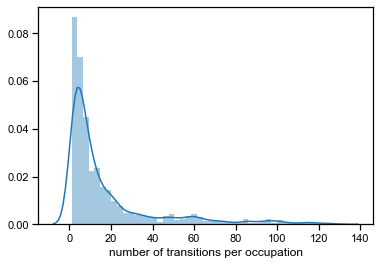

In [9]:
sns.distplot(safe_validated_transitions.groupby('origin_id').count().destination_id)
plt.xlabel('number of transitions per occupation')
plt.show()

In [10]:
# Fraction of all top level ESCO occupations featured in the table as origin/destination 
print(len(safe_validated_transitions.origin_id.unique()) / len(data.report_occ_ids))
print(len(safe_validated_transitions.destination_id.unique()) / len(data.report_occ_ids))

0.9293177627535341
0.828518746158574


# 2. Manual curation

In [11]:
# It might be confusing to be recommended transitions to these roles;
# hence, we take them out
filter_out = [
    'escort',
    'fortune teller', 'psychic', 'medium',
]

In [12]:
curated_transitions = safe_validated_transitions.copy()
curated_transitions = curated_transitions[-curated_transitions.origin_label.isin(filter_out)]
curated_transitions = curated_transitions[-curated_transitions.destination_label.isin(filter_out)]
print(f"Total number of 'feasible', curated safe and desirable transitions: {len(curated_transitions)}")

Total number of 'feasible', curated safe and desirable transitions: 26642


# 3. Output a curated table in supplementary online data


In [13]:
# Add risk category
transitions = curated_transitions.copy()
transitions=data.add_field_to_occupation(transitions, 'origin_id', 'risk_category', 'origin')
transitions=data.add_field_to_occupation(transitions, 'destination_id', 'risk_category', 'destination')

for only_high_risk_cols in ['is_safer', 'is_strictly_safe', 'is_strictly_safe_desirable']:
    transitions.loc[-(transitions.origin_risk_category=='High risk'), only_high_risk_cols] = np.nan

In [14]:
transitions = transitions[[
    'origin_id', 'origin_label', 'destination_id', 'destination_label',
    'similarity', 'sim_category', 'feasibility', 'is_feasible', 'feasibility_predicted', 'is_feasible_predicted',
    'W_skills', 'W_work',
    'W_essential_skills', 'W_optional_skills', 'W_activities', 'W_work_context',
    'job_zone_dif', 'earnings_ratio', 'risk_dif', 'prop_dif',
    'origin_risk_category', 'destination_risk_category',
    'is_viable', 'is_desirable', 'is_safe_desirable', 'is_strictly_safe_desirable'
]]

In [15]:
transitions.sample(3)

,origin_id,origin_label,destination_id,destination_label,similarity,sim_category,feasibility,is_feasible,feasibility_predicted,is_feasible_predicted,...,job_zone_dif,earnings_ratio,risk_dif,prop_dif,origin_risk_category,destination_risk_category,is_viable,is_desirable,is_safe_desirable,is_strictly_safe_desirable
25304,2745,refining machine operator,1855,dairy processing operator,0.492862,highly_viable,NaN,NaN,2.889763,True,...,0.0,1.000000,-0.017130,0.057178,Other,Other,True,True,True,NaN
20939,2233,metallurgist,83,metallurgical technician,0.496165,highly_viable,NaN,NaN,3.132885,True,...,0.0,0.752436,0.000000,0.000000,Other,Other,True,True,True,NaN
15848,1709,real estate agent,192,real estate manager,0.420148,highly_viable,3.75,True,2.550225,True,...,-1.0,1.000000,0.138457,0.313103,High risk,Other,True,True,True,1.0


In [16]:
transitions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26642 entries, 0 to 26641
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   origin_id                   26642 non-null  int64  
 1   origin_label                26642 non-null  object 
 2   destination_id              26642 non-null  int64  
 3   destination_label           26642 non-null  object 
 4   similarity                  26642 non-null  float64
 5   sim_category                26642 non-null  object 
 6   feasibility                 4440 non-null   float64
 7   is_feasible                 4440 non-null   object 
 8   feasibility_predicted       26642 non-null  float64
 9   is_feasible_predicted       26642 non-null  bool   
 10  W_skills                    26642 non-null  float64
 11  W_work                      26642 non-null  float64
 12  W_essential_skills          26642 non-null  float64
 13  W_optional_skills           266

In [17]:
transitions.to_csv(output_folder + file_name, index=False)
